In [1]:
import os
import sys
sys.path.append("..")

In [2]:
from model import YModel, OptLoss
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


In [3]:
from comet_ml import API
import comet_ml

%matplotlib inline

In [4]:
from collections import defaultdict

In [5]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [6]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(500))

In [7]:
comet_api = API()
comet_api.get()
metrics = defaultdict(list)
for experiment in comet_api.get("shir994/sigmoid-optim/"):
    
    hyper_params = {}
    for param in experiment.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    
    extract_metrics(experiment, hyper_params, metrics, mask)

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Check model

In [8]:
exp = comet_api.get("shir994/sigmoid-optim/d74551a122d74b6890eb542a660dcd04")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [9]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [10]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [11]:
import io

asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "sigmoid_optim_opt.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))

In [12]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [13]:
generator.load_state_dict(state_dict['gen_state_dict'])

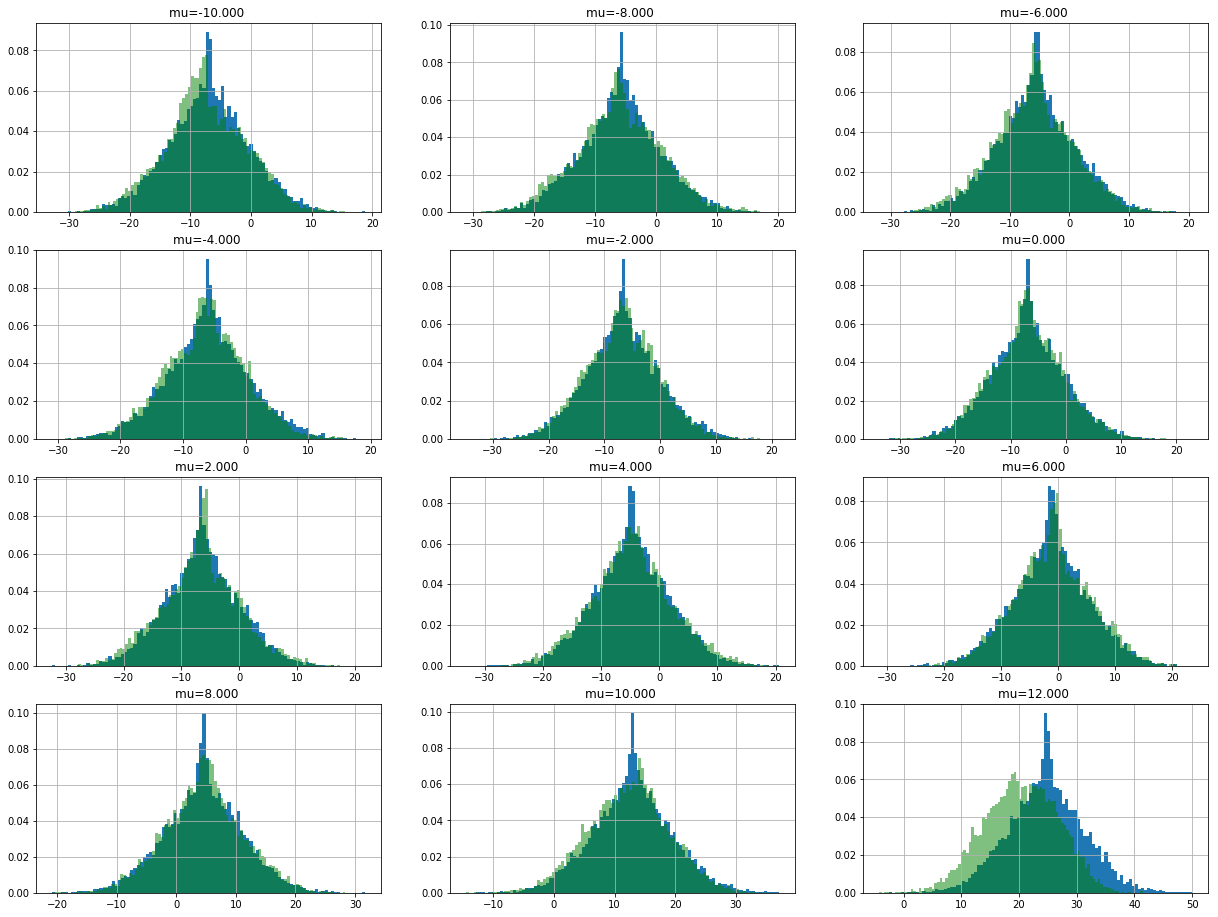

In [48]:
plt.figure(figsize=(21,16))
mu_range = list(range(-10, 13, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        mu = torch.tensor([float(mu_range[i*3 + j])] * 10000)
        y_sampler.make_condition_sample({'mu': mu})

        x = y_sampler.x_dist.sample(mu.shape).to(device)
        mu = mu.to(device)
        oise = noise = torch.Tensor(sample_noise(mu.shape[0], NOISE_DIM)).to(device)

        plt.hist(y_sampler.condition_sample().cpu().numpy(), bins=100, density=True, label='true');
        plt.hist(generator(noise, torch.stack([mu,x],dim=1)).detach().cpu().numpy(),
                 bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        #plt.legend()
        plt.title("mu={:.3f} ".format(mu_range[i*3 + j]))

# Test optimisation

In [24]:
losses = []
for mu in np.linspace(-20, 20, 100):
    mu_samples = torch.tensor(float(mu)).reshape(-1,1).repeat(10000, 1)
    y_sampler.make_condition_sample({"mu":mu_samples})
    y = y_sampler.condition_sample()
    losses.append(OptLoss.SigmoidLoss(y, -5, 5).mean().item())

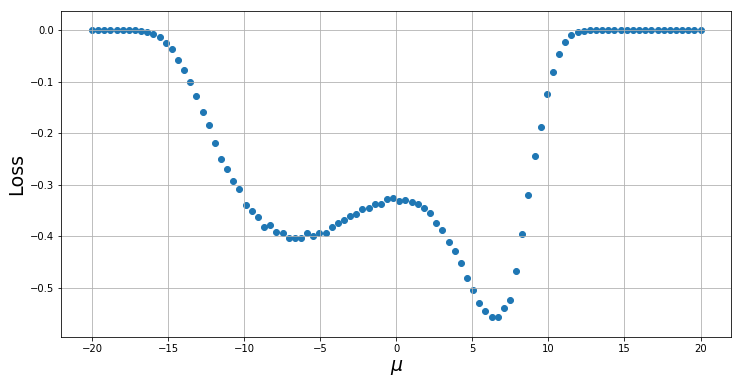

In [28]:
plt.figure(figsize=(12,6))
plt.scatter(np.linspace(-20, 20, 100), losses)
plt.xlabel(f"$\mu$", fontsize=19)
plt.ylabel("Loss", fontsize=19)
plt.grid()

In [20]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [79]:
io_model = InputOptimisation(generator)

lr = 3.
sample_size = 1000


mu_optim = torch.tensor(-10.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [80]:
%%time
n_iter = 10000
losses = []
m_vals = []
for _iter in range(n_iter):    
    noise = torch.Tensor(sample_noise(sample_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.stack([mu_optim, x], dim=1))
    loss = OptLoss.SigmoidLoss(data_gen, -5, 5)
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())

CPU times: user 14.9 s, sys: 592 ms, total: 15.5 s
Wall time: 15.1 s


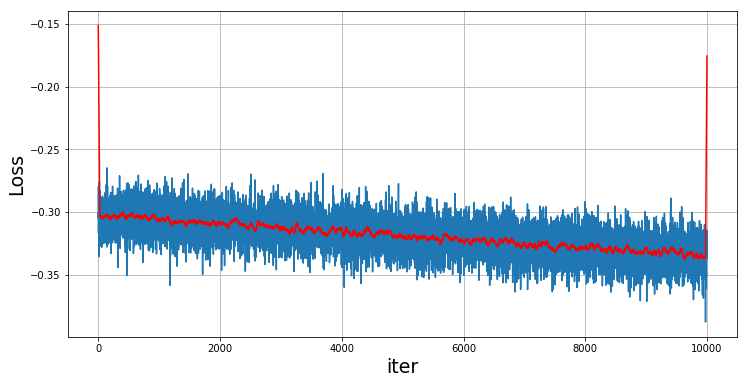

In [81]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

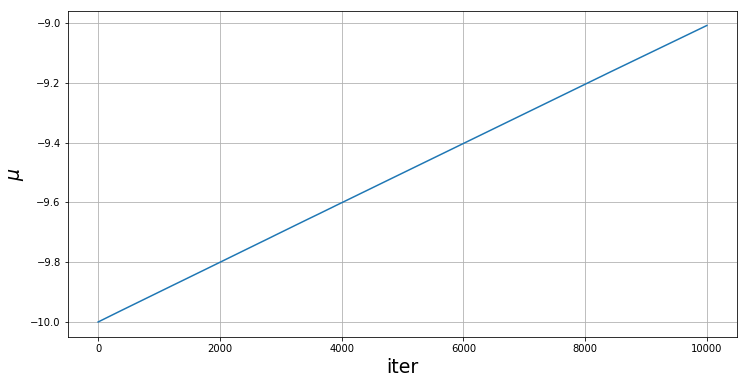

In [82]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [66]:
m_vals[-1]

6.745800018310547

In [85]:
def find_mu(init_mu, n_iter=100000):
    io_model = InputOptimisation(generator)
    mu_optim = torch.tensor(float(init_mu))
    mu_optim = mu_optim.repeat(sample_size).to(device)
    mu_optim.requires_grad=True
    
    #losses = []
    #m_vals = []
    for _iter in range(n_iter):    
        noise = torch.Tensor(sample_noise(sample_size, NOISE_DIM)).to(device)
        x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
        # Do an update
        data_gen = io_model(noise, torch.stack([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, -5, 5)
        #losses.append(loss.item())
        io_model.zero_grad()
        loss.backward()
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean()
            mu_optim.grad.zero_()
        #m_vals.append(mu_optim[0].item())
    return mu_optim[0].item()

In [90]:
opt_mu = []
for mu in np.arange(-15, 15, 1):
    opt_mu.append(find_mu(mu))

Text(0.5, 0, '$\\mu_{initial}$')

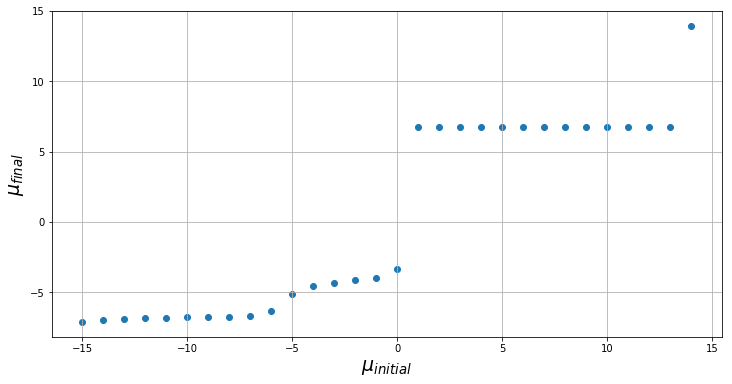

In [92]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(-15,15,1), opt_mu)
plt.grid()
plt.ylabel("$\mu_{final}$", fontsize=19)
plt.xlabel("$\mu_{initial}$", fontsize=19)